In [1]:
import os
import json
import copy
import pandas as pd
import matplotlib
font = {'family' : 'normal', 'size'   : 22}
matplotlib.rc('font', **font)
import matplotlib.pyplot as plt

In [2]:
# List result Files
experiment_files = [a for a in os.listdir("./out") if ".json" in a]

# Load result Files
all_experiments = []
for filename in experiment_files:
    with open("./out/{}".format(filename), "r") as f:
        all_experiments.append(json.load(f))

# Aglomerate similar results
unique_experiment_names = list(dict.fromkeys([a["model"] for a in all_experiments]))
print(unique_experiment_names)

sorted_experiments = {}
for e in unique_experiment_names:
    sorted_experiments[e] = []

for e in all_experiments:
    sorted_experiments[e['model']].append(e)

['dummy']


In [3]:
baseline = sorted_experiments['dummy']

total_energy = sum([b['joules1'] for b in baseline])
total_seconds = sum([b['seconds'] for b in baseline])
baseline_power = total_energy/total_seconds
print(baseline_power)

3.9705764947999995


In [4]:
aggregated_experiments = []

for exp_name, exp_list in sorted_experiments.items():
    joules = sum([e['joules1'] for e in exp_list])
    seconds = sum([e['seconds'] for e in exp_list])
    corrected_joules = joules - baseline_power*seconds
    num_images = sum([e['num_images'] for e in exp_list])
    aggregated_experiments.append({
        "mAP": exp_list[0]['map'],
        "inference_time": 1e3*seconds / num_images,
        "KB": exp_list[0]['bw']/1e3,
        "joules": joules,
        "seconds": seconds,
        "corrected_joules": joules - baseline_power*seconds,
        "corrected_watts": (joules - baseline_power*seconds)/seconds,
        "corrected_joules_per_image": corrected_joules / num_images,
        "num_images": num_images,
        "model": exp_name,
        "GMAC": exp_list[0]['macs']/1e9,
        "params(K)": exp_list[0]['params']/1e3,
    })
    
with open("test.json", "w+") as f:
    json.dump(aggregated_experiments, f)

In [5]:

df = pd.read_json('test.json')
df = df.set_index("model")
df = df.sort_index(ascending=True)
df = df.drop(["joules", "seconds","corrected_joules", "num_images"], axis=1)

rename_map = {
    "corrected_joules_per_image": "Joules",
    "corrected_watts": "Watts",
    "inference_time": "ms",
}

df = df.rename(rename_map, axis=1)

df['Watts'] = df['Watts'].round(2)
df['Joules'] = df['Joules'].round(2)
df['ms'] = df['ms'].round(0).astype(int)
df['GMAC'] = df['GMAC'].round(3)
df['KB'] = df['KB'].round(1)
df['mAP'] = df['mAP'].round(1)
df['params(K)'] = df['params(K)'].round(1)
print(df)

df_back = copy.copy(df)


a = df.reindex(["assine2022a_25", "assine2022a_75", "assine2022a_100"])

       mAP   ms  KB  Watts  Joules  GMAC  params(K)
model                                              
dummy    0  105   0      0       0     0          0


In [6]:
print(df.to_latex()) 

\begin{tabular}{lrrrrrrr}
\toprule
{} &  mAP &   ms &  KB &  Watts &  Joules &  GMAC &  params(K) \\
model &      &      &     &        &         &       &            \\
\midrule
dummy &    0 &  105 &   0 &      0 &       0 &     0 &          0 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_438/3246126283.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex())


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


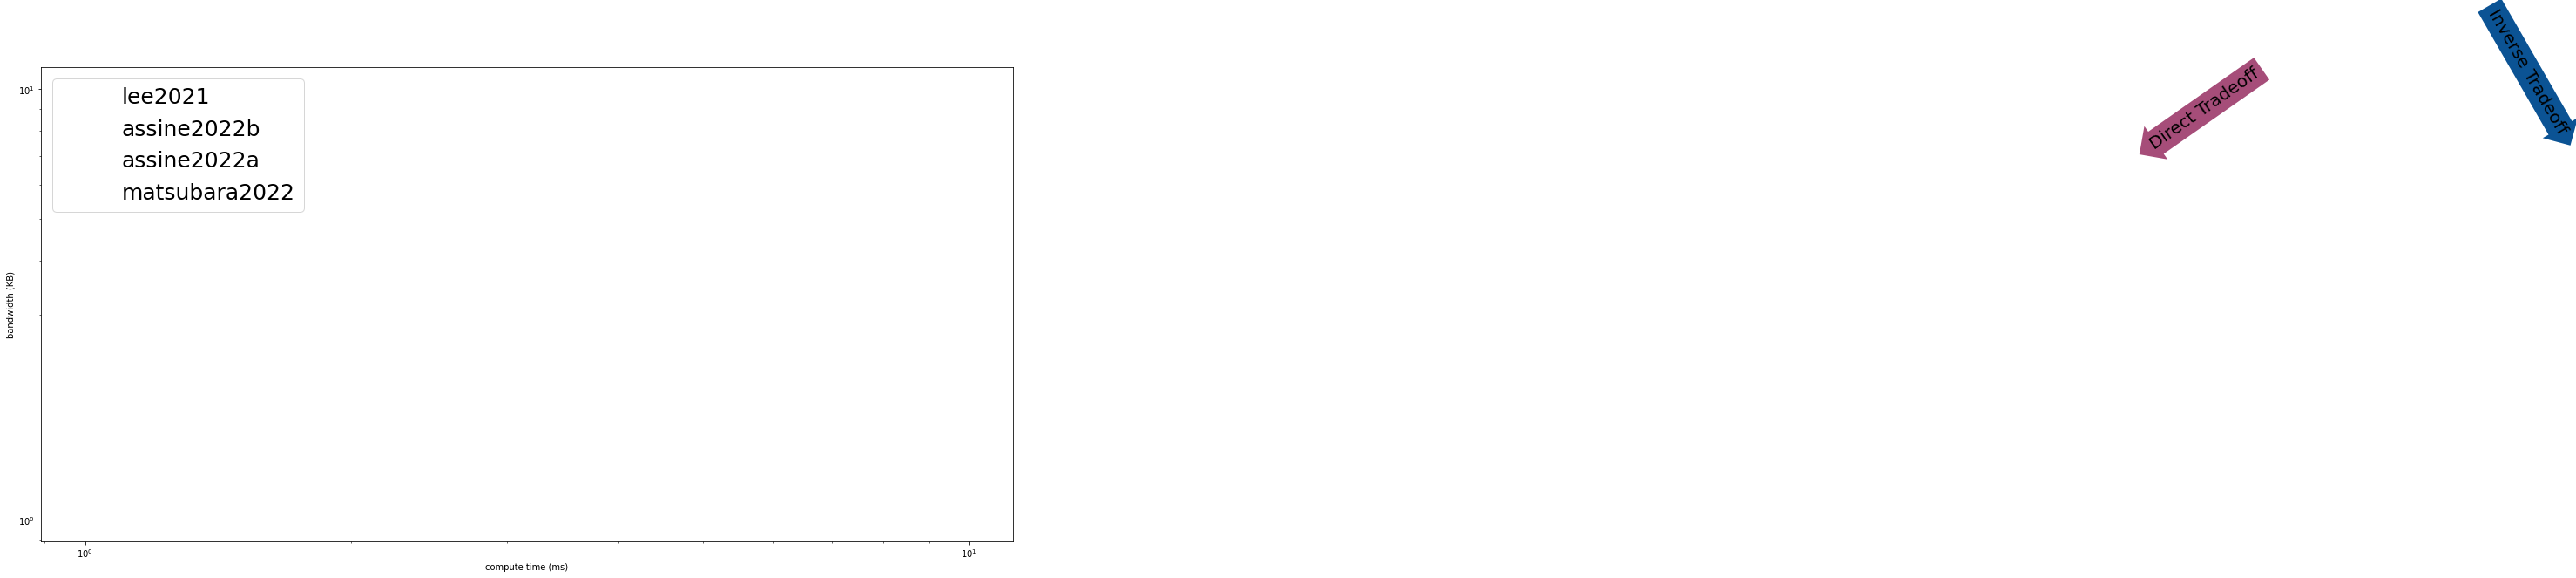

In [7]:


df = copy.copy(df_back)
###########################################################################
def plot(ax, name, color='blue', marker='o', configurable=False):
    a = df[df.index.str.contains(name)]
    bw = a['KB'].values
    latency = a['ms'].values
    mAP = a['mAP'].values
    
    z = 2.5*(mAP**2)
    z_label = ["{:2.1f}".format(m) for m in mAP]
    
    vmin=14.0
    vmax=40.0
    
    if configurable:
         ax.scatter(latency, bw, s=z, marker=marker, alpha=1.0, 
                    label=name, #linewidth=2,
#                     edgecolor='black',
                    c=mAP, cmap='viridis', vmin=vmin, vmax=vmax)
    else:
        ax.scatter(latency, bw, s=z, marker=marker, alpha=1.0,
                   label=name,
#                    edgecolor='black',
                   c=mAP, cmap='viridis', vmin=vmin, vmax=vmax)
    for i in range(len(mAP)):
        ax.annotate(z_label[i], ( latency[i], bw[i]), ha='center', va='center', fontsize=18, color='black')



fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.set_xlabel('compute time (ms)')
ax.set_ylabel('bandwidth (KB)')
ax.set_xscale('log')
ax.set_yscale('log')

f = "literature_comparison/literature.csv"
df.columns = df.columns.str.replace(' ', '')
plot(ax, "lee2021", color='cyan', marker='s')
plot(ax, "assine2022b", color='red', marker="D", configurable=True)
plot(ax, "assine2022a", color="#A8127D", marker="o", configurable=True)
plot(ax, "matsubara2022", color='blue', marker="p")

# plot("assine", color='black',  configurable=True)

# bb = t.get_bbox_patch()
# bb.set_boxstyle("rarrow", pad=0.6)



# bbox_props = dict(boxstyle="rarrow", fc=(0.7, 0.1, 0.1), ec="b", lw=0)
bbox_props = dict(boxstyle="rarrow", fc="#0b5394", ec="b", lw=0)
t = ax.text(580, 1.1e1, "Inverse Tradeoff", ha="center", va="center", rotation=-60,
            size=20,
            bbox=bbox_props)

# bbox_props = dict(boxstyle="larrow", fc=(0.1, 0.1, 0.7), ec="b", lw=0)
# t = ax.text(210, 9, "Direct Tradeoff", ha="center", va="center", rotation=40,
#             size=18,
#             bbox=bbox_props)
bbox_props = dict(boxstyle="larrow", fc="#a64d79", ec="b", lw=0)
t = ax.text(250, 9, "Direct Tradeoff", ha="center", va="center", rotation=35,
            size=20,
            bbox=bbox_props)

legend_properties = {'weight':'bold', 'size': 16}
legend_properties = {'size': 25}
lgnd = ax.legend(fontsize=15,  prop=legend_properties, loc='upper left',)#bbox_to_anchor=(0.1, 0.6),
lgnd.legendHandles[0]._sizes = [1e3]
lgnd.legendHandles[1]._sizes = [1e3]
lgnd.legendHandles[2]._sizes = [1e3]
lgnd.legendHandles[3]._sizes = [1e3]

plt.savefig(os.path.join("./out", "graph_sota.pdf"))
plt.show()


[]

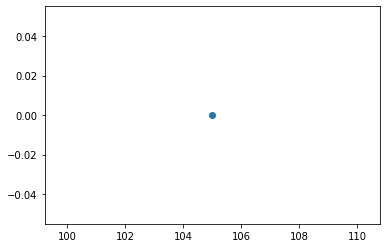

In [8]:
plt.scatter(df['ms'], df['Joules'])
plt.plot()



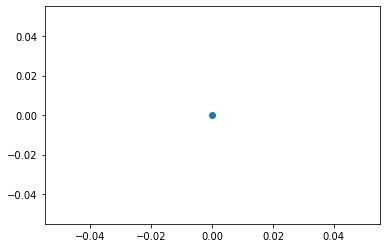

In [9]:

plt.scatter(df['params(K)'], df['Watts'])
